In [2]:
import gmsh
import pyvista
import ufl
import numpy as np

#from basix.ufl import element, mixed_element
from ufl import FiniteElement
from dolfinx import fem, plot
from dolfinx.fem import Function, FunctionSpace
from dolfinx.io import gmshio, XDMFFile
from dolfinx.mesh import locate_entities, meshtags
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import FacetNormal, Measure, MixedElement
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

## Physical Parameters

In [3]:
R = 1                   # Radius of domain
nel = 32                # Number of electrodes
wel = np.pi / nel       # Width of electrode
phase = np.pi / 2       # The starting angle of anti-clockwise electrode indexing

sigma0 = 0.8            # Conductivity of the background
sigma1 = 1e2            # Conductivity of conductive region
sigma2 = 1e-2           # Conductivity of the resistitve region

z = np.full(nel, 1e-6)  # The contact impedance of the different electrodes

# Mesh

We generate a circular mesh using the python interface for GMSH. We start by initializing GMSH and add a disk centred at the origin. 

In [4]:
gmsh.initialize()

# Add disk to the GMSH geometry
domain = gmsh.model.occ.addDisk(0, 0, 0, R, R)
gmsh.model.occ.synchronize()

# Make domain a physical surface so it is recognised by GMSH
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [domain], 1)

gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.02)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.02)
gmsh.model.mesh.generate(gdim)

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
mesh, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
gmsh.finalize()

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000186583s, CPU 0.000241s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.292151s, CPU 0.284608s)
Info    : 9335 nodes 18669 elements


## Plotting the Mesh

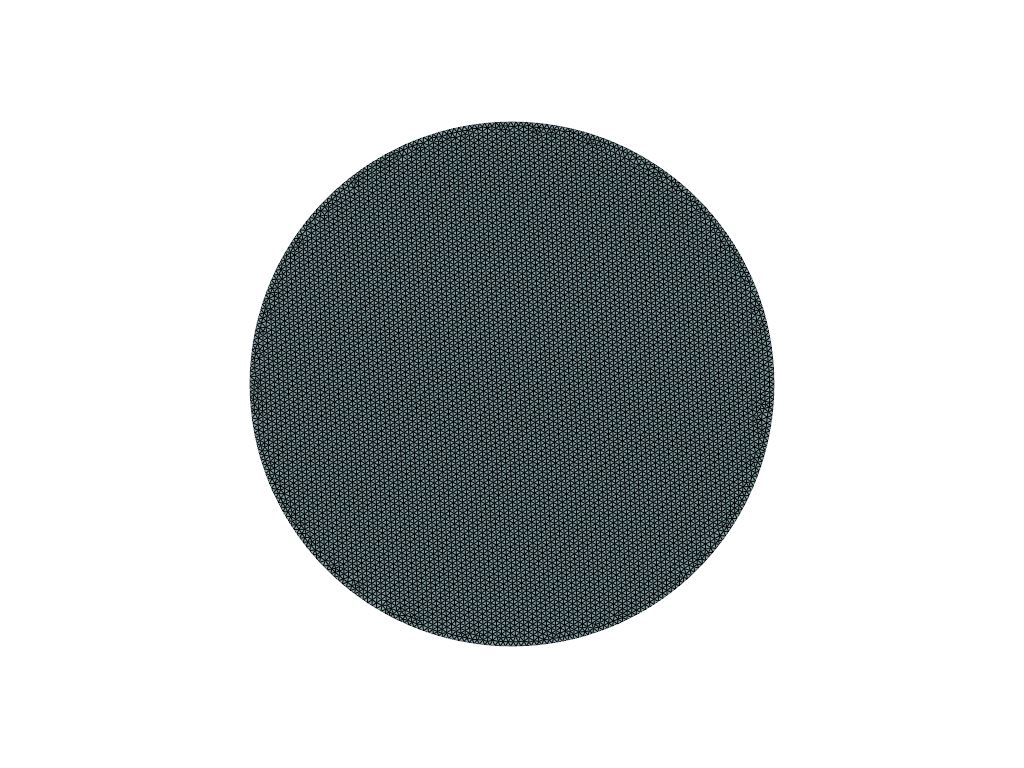

In [4]:
pyvista.set_jupyter_backend("static")

topology, cell_types, geometry = plot.create_vtk_mesh(mesh, gdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

# Create Subdomains

In [5]:
def on_boundary(x, y):
    l = np.square(x) + np.square(y)
    return np.isclose(l, R ** 2)


def on_electrode(x, y, e):
    # Compute the euclidean norm of (x, y)
    r = np.sqrt(np.square(x) + np.square(y))

    # Compute the coordinates of the centre of the electrode
    theta = 2 * np.pi * e / nel + phase
    u, v = R * (np.cos(theta), np.sin(theta))

    # Compute the angle between (x,y) and (u,v)
    rho = np.arccos((x * u + y * v) / (r * R))

    # Project the angular distance onto the boundary of the electrode
    proj = np.maximum(2 * np.abs(rho), wel) 

    # Determine if (x, y) is on the electrode
    return np.logical_and(np.isclose(r, R), np.isclose(proj, wel))

In [14]:
# Locate subdomains
fdim = mesh.topology.dim - 1
facet_indices, facet_markers = [], []
for e in range(nel):
    # Define distance function for the electrode
    d = lambda x: on_electrode(x[0], x[1], e)

    # Locate facets on the electrode and add to lists
    facets = locate_entities(mesh, fdim, d)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, e))


facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

print(facet_indices)

[21168 21474 21692 21780 18600 18928 19256 19582 15788 16135 16475 16816
 12303 12652 13001 13350  8853  9198  9537  9883  5600  5914  6229  6552
  2811  3020  3264  3537  1053  1201  1355  1513    60   118   188    30
    34    38    39   166   186   243   262   559   672   773   797  1527
  1674  1695  1868  3037  3281  3320  3321  3040  3044  3260  3302  3605
  3606  3812  3887  4979  5069  5287  5377  6962  7288  7616  7944  9975
 10318 10661 11004 13442 13791 14140 14489 16911 17251 17594 18171 20451
 20768 21081 23128 23403 23655 23891 25401 25584 25765 25938 26949 27063
 27171 27268 27678 27682 27685 27686 27558 27605 27606 27609 27242 27245
 27334 26363 26513 26520 26658 24753 24954 25150 25344 23491 23659 23662
 23665 22938 22941 23132 23217]


To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file. We can then inspect individual boundaries using the Threshold-filter

In [7]:
# TODO: Fix this
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
with XDMFFile(mesh.comm, "facet_tags.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(facet_tag)

Now we can create a custom integration measure ds, which can be used to restrict integration. If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag.

In [11]:
dx = Measure("dx", domain=mesh)
ds = Measure("ds", domain=mesh, subdomain_data=facet_tag)

# Weak Formulation

In [6]:
# Use the standard Lagrange family of elements to represent the Sobolev space
H = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
#H = FunctionSpace(mesh, ("CG", 1))

# Use mean free real valued vectors to represent electrode potentials
# See: https://fenicsproject.discourse.group/t/real-element-type-in-dolfinx/8956
K = FiniteElement("Real", mesh.ufl_cell(), 0)
#Rn = MixedElement([F for _ in range(nel)])

# Construct direct sum space
W = FunctionSpace(mesh, MixedElement([H] + [K for _ in range(nel + 1)]))
#W = FunctionSpace(mesh, MixedElement(H, [K for _ in range(nel + 1)]))

# Use piecewise constant functions to represent the conductivity
P = FunctionSpace(mesh, ("CG", 1))

# Construct test and trial functions
(u, *U) = ufl.TrialFunction(W)
(v, *V) = ufl.TestFunction(W)

In [8]:
# Define sigma to be the background conductivity
sigma = Function(P)
sigma.interpolate(lambda _: np.array([sigma0]))

# Compute the area of the domian
#area = fem.assemble_scalar(fem.form(1 * dx))

a = ufl.inner(ufl.grad(u), ufl.grad(v)) * dx
for e in range (nel):
    a += 1 / z[e] * (u - U[e]) * (v - V[e]) * ds(e)

    # Enforce mean free electrode potentials
    area = fem.assemble_scalar(fem.form(1 * ds(e)))
    a += (V[nel] * U[e] + U[nel] * V[e]) / area * ds(e)

#A = fem.assemble_matrix(fem.form(a))

J = np.zeros(nel)
J[0] = 1
J[2] = -1

L = 0 * dx
for e in range(nel):
    area = fem.assemble_scalar(fem.form(1 * ds(e)))
    L += J[e] * V[e] / area * ds(e)

NameError: name 'dx' is not defined

In [11]:
problem = fem.petsc.LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu",
                                                      "pc_factor_mat_solver_type": "mumps"})

soln = problem.solve()
uh, *Uh = soln.split()

# Plot the solution

()
()
[inf inf inf ... inf inf inf]


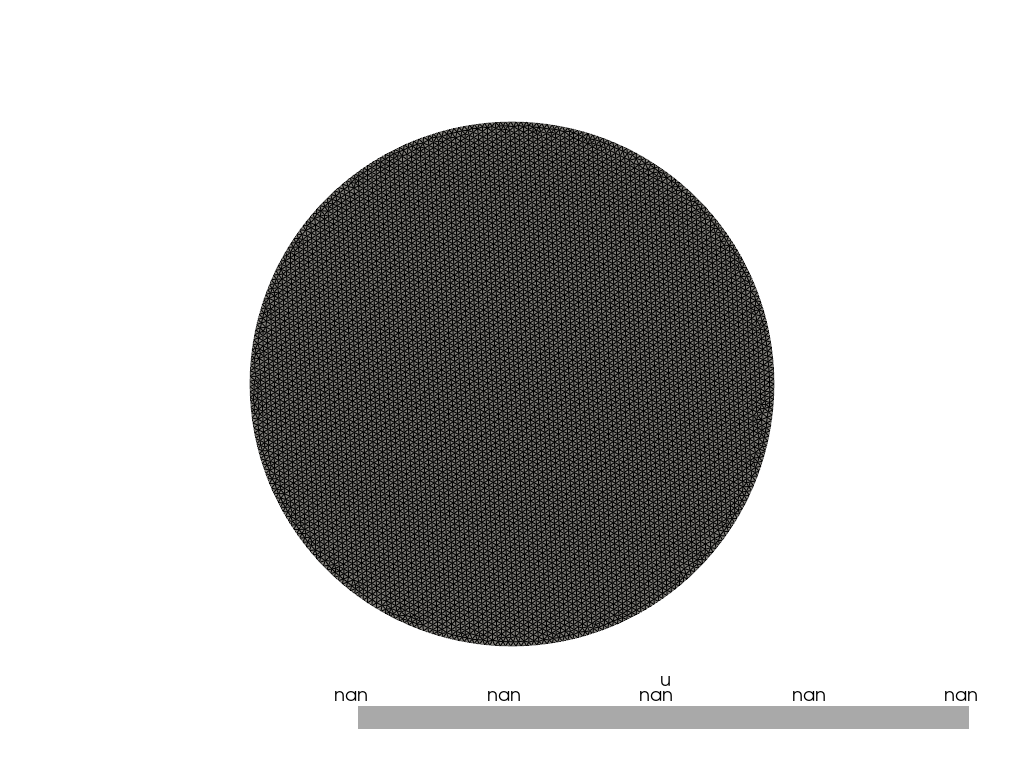

In [12]:
topology, cell_types, geometry = plot.create_vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

print(uh.ufl_shape)
print(Uh[nel].ufl_shape)
print(Uh[0].x.array)
#grid.point_data["u"] = uh.x.array.real
grid.point_data["u"] = Uh[0].x.array.real
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()